# Relatório de Sequenciamento Genético

Este relatório tem como foco o problema de alinhamento de sequências de DNA, que consiste no processo de comparar duas ou mais sequências de bases, de forma a se observar seu nível de similaridade. Esse nível de similaridáde é definído pela pontuação feita na comparação entre as duas sequências.

O Cálculo dessa pontuação é encontrado usando as seguinte regras:
    - Cada comparação será feita um único caracter de cada sequência.
    - Se a comparação for um MATCH soma +2 ao valor total.
    - Se a comparação for um MISMATCH soma -1 ao valor total.
    - Se a comparação for um GAP soma -1 ao valor total.

Abaixo segue exemplo de como as regras de contuação interagem:

<span style="color:red">MISMATCH</span> 
<span style="color:blue">GAP</span> 
<span style="color:green">MATCH</span> </br>

![Cálculo do alinhamento](./alignment.png "alignment.png")

Usamos 3 tipos de abordagem para lidar com esse problema.

- [Heurística (Smith-Walterman)](/heuristica/heuristica.ipynb)

- [Busca Local](/busca_local/busca_local.ipynb)

- [Busca Exaustiva](/busca_exaustiva/busca_exaustiva.ipynb)

Os gráficos a seguir foram construídos utilizando 100 arquivos de input. Cada um possui a seguinte estruturação:
- Tamanho da sequência 1
- Tamanho da sequência 2
- Sequência 1 gerada de forma aleatória
- Sequência 2 gerada de forma aleatória

Pode visualizar um exemplo nesse [link](/testes/input01.seq)

## Fazendo imports

In [1]:
import os
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Criando listas que cotém o tamanho das sequências

In [42]:
with open('n-sizes') as f:
    list_n = f.read().split("\n")
    del list_n[-1]
testes = os.listdir('testes')
testes.sort()
with open('m-sizes') as f:
    list_m = f.read().split("\n")
    del list_m[-1]

with open('n-sizesE') as f:
    list_nE = f.read().split("\n")
    del list_nE[-1]
testesE = os.listdir('testes_exaustivo')
testesE.sort()
with open('m-sizesE') as f:
    list_mE = f.read().split("\n")
    del list_mE[-1]

## Função para calcular o teste "t" para a o algorítimo "e" especificado:

In [43]:
def roda_com_entrada(t, e):
  with open(f'testes/{t}') as f:
    start = time.perf_counter()
    proc = subprocess.run([e], input=f.read(), text=True, capture_output=True)
    end = time.perf_counter()
  return [end-start, proc.stdout]

In [44]:
list_smith = []
list_smith_result = []
list_local = []
list_local_result = []
list_local_omp = []
list_local_omp_result = []
list_exaustiva = []
list_exaustiva_result = []

In [51]:
for t in testes:
  # tmp = roda_com_entrada(t,'./smith')
  # list_smith.append(tmp[0])
  # list_smith_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local')
  list_local.append(tmp[0])
  list_local_result.append(tmp[1])
  tmp = roda_com_entrada(t,'./local_omp')
  list_local_omp.append(tmp[0])
  list_local_omp_result.append(tmp[1])

In [39]:
# for t in testesE:
#   print(t)
#   tmp = roda_com_entrada(t,'./exa')
#   list_exaustiva.append(tmp[0])
#   list_exaustiva_result.append(tmp[1])

## Gráfico para a Heurística

In [ ]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_smith,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Smith-Walterman');

O gráfico acima nós mostra que quanto maior for o tamanho da sequência mais tempo irá demorar para que o programa execute. Isso se dá pelo fato do Smith ser um algoritmo que cria uma matriz que vai relacionar todos os caracteres de uma sequência a todos os caracteres da outra sequência. Esse tipo de algoritmo é classificado como algoritmos de exploitation, pois eles olham de forma sequencial os máximos locais. O que demanda tempo pois funciona como uma varredura nas possibilidades.

## Proffiling

O principal responsável pelo decaimento do desempenho do código com relação ao tempo é a criação da matriz. Pois se tivermos sequências muito grandes a matriz será maior ainda. 
Como forma de verificação dessa afirmação, gerei um valgrind do executável.

![Valgrind](vall_smith.png "vall_smith.png")


## Gráfico para a Busca Local

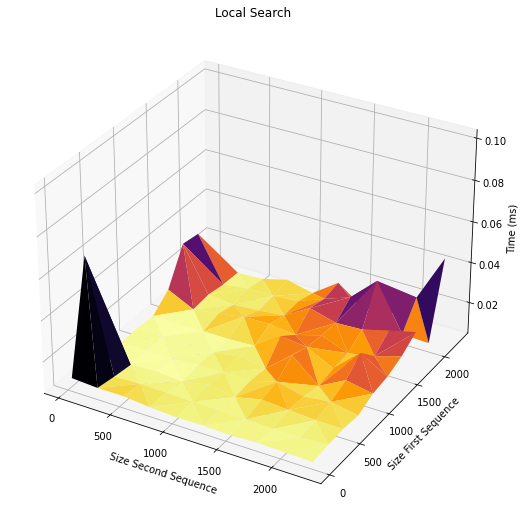

In [52]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_local,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Local Search');

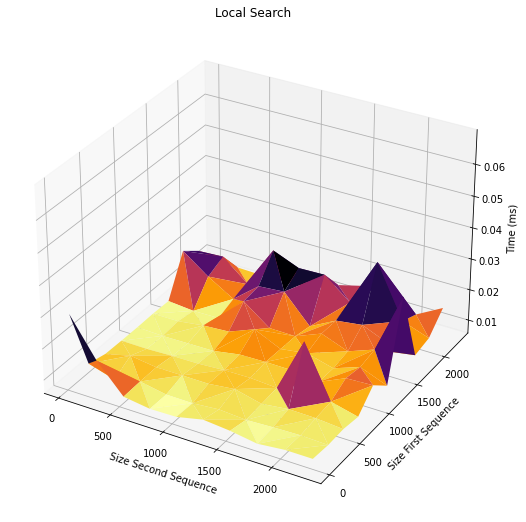

In [53]:
graph = plt.figure(figsize=(30,55))
smithG = graph.add_subplot(133, projection='3d')
smithG.plot_trisurf(list_m, list_n, list_local_omp,cmap='inferno_r')
smithG.set_xlabel('Size Second Sequence')
smithG.set_ylabel('Size First Sequence')
smithG.set_zlabel('Time (ms)')
smithG.set_title('Local Search');

O algoritmo de busca local performa com uma velocidade menor que a do Smith. Mas isso se deve ao fato dele ser um algoritmo focado em exploration e não em exploitation. Algoritmos de exploração olham para posições  aleatórias da sequência, no intuito de eventualmente achar casos melhores que os seus locais. Isso gera muitos resultados ruins, porém diminui consideravelmente o tempo de processamento para sequências gigantes.

Ao incluir o parallel for no código, foi interessante notar que o gráfico parece ter menos ruídos pois eles vinham da parte que estamos otimizando agora que é o cálculo do score das substrings. Porém, agora é ainda mais destacado algo que não avia sido concluido antes. Se levarmos em consideração que a probabilidade de um caracter ser considerado match é cinco vezes menor que a probabilidade de estar errado então quanto maior for a nossa string 

## Proffiling

O principal responsável pelo decaimento do desempenho do código com relação ao tempo é a chamada recursiva que ele faz para usar o algoritmo. O que faz sentido pois ele não necessita da criação de uma matriz como o algoritmo acima.

![Valgrind](vall_local.png "vall_local.png")

## Gráfico para a Busca Exaustiva

Tive alguns problemas rodando o algoritimo da busca exaustiva utilizando python.
Por algum motivo o mesmo executável se recusa a rodar através da execução utilizando o run do subprocess em python. Mas quando executado pelo terminal ele performa muito bem, como é possível ver no comparativo abaixo.
("exa_print"=="exa"+COUT => Logo, exa era pra performar melhor que exa_print)

![exa_print](terminal_exaustiva.png)

Compreendo que o print abaixo esteja redundante, mas já tirei a redundancia do codigo de criação da lista de exaustiva e mesmo assim demora 20 minutos e não conclui nem o [input04.seq](/testes_exaustivo/input04.seq), o que usando pelo terminal conclui em menos de 2 minutos outros até mais longos.

![exa_python](exa_python.png)

Tendo em vista que os outros algoritimos executam cadeias bem mais longas que [essas](/testes_exaustivo/) que estou passando para a exaustiva, e em poucos segundos, a conclusão que tiro é que pelo fato da Exaustiva repetir o cálculo do Smith ou da busca-local para cada combinação sequenciada possível de suas sequências ela funciona quase como um cálculo com fatorial, parece consufo o que estou falando, mas vou exemplificar:
- Para sequencias de mesmo tamanho
- Se fizermos o Smith para uma sequencia de tamanho N e depois para uma de tamanho N+1, a diferença de células processadas será de (2N + 1) o que já é um aumento considerável.
- Já no caso da Exaustiva para uma sequencia de tamanho N e depois para uma de tamanho N+1, a diferença de células processadas será de (2N + 1)(N+1)³, tendo em vista que a construção da exaustiva foi feita somente com o uso do Smith-Walterman e não com o da Busca Local. Para um N muito grande o dominante na equação se torna o (N+1)³, que tem seu comportamento expresso no gráfico a baixo:

![n3](n3.png) ![tabn3](tabela_n3.png)

A equação encontrada na tabela foi modelada por mim com base nas constraints que especifiquei acima e no comportamento natural da exaustiva modelada em código. (Meu código está um pouco diferente pois leva em consideração que para sequencias de tamanhos similares será feito o cálculo similar ao da busca local que é o mais simples. Porém como dito anteriormente a parte dominante do algorítimo é o modelo que calculei a cima que é estritamente ligado ao crescimento da busca exaustiva, logo provando assim que não faz diferença se você usa Smith ou uma comparação direta para fazer os calculos de máximo.)

    Caso seja necessário tenho a construção da modelagem em foto. Tá um pouco bagunçada mas posso explicar o raciocínio sem problema. Tenho dislexia e por isso me sinto muito desconfortável escrevendo textos muito longos. Mas se for necessário, posso aprontar uma apresentação de powerpoint para explicar meu raciocínio lógico.

# Conclusão

Tendo em vista que o comportamento da busca-local segue um padrão mais randomico e distribuido em termos de tempo de processamento e que seus resultados podem vir a ser muito ruins, não compensando muito a economia com tempo, os dois que tem mais credibilidade são a Exaustiva e o algoritimo de Smith.

Olhando para os dados e modelos apresentados conseguimos concluir que por ter um crescimeto, para N>1, exponencial, a busca exaustiva se mostra um algoritimo somente necessário em caso de necessidade de sempre obter o melhor caso global como retorno. Porém para soluções em que cabem máximos locais o Smith_walterman será um algoritimo bem mais eficiente em termos de tempo de custo-benefício.